# Fake and Real News

Model to determine if an article is fake news or not ?

## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


## Load the dataset and validate the data load

We will load the individual dataset, create a target attribute which will indicate 1 if the news is fake. Combine both the dataframes and create the combined dataframe for modelling

In [3]:
# Load the fake and real news datasets
fake_news = pd.read_csv("resources/Fake.csv")
fake_news["fake"] = 1

# Load the real news 
real_news = pd.read_csv("resources/True.csv")
real_news["fake"] = 0

# We will join the two dataframes and create the combined one for modelling

news = pd.concat([fake_news, real_news])
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [4]:
# Check for any null values
news.isna().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

In [5]:
# Check the data structure
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


## Exploratory Data Analysis - Data Visualizations

#### Explore the target variable

Distributions...
1    23481
0    21417
Name: fake, dtype: int64


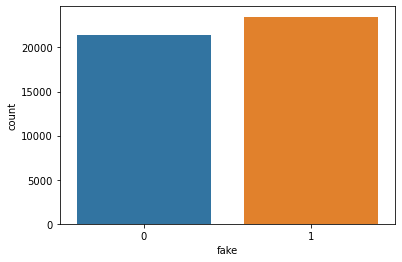

In [6]:
# Explore the target variable
sns.countplot(x='fake', data=news)
print("Distributions...")
print(news['fake'].value_counts())

We see good distibution of data in both the classes

#### Explore at least 2 texts from each class

In [7]:
# Explore 2 texts for the fake dataset
news[news['fake'] == 1]['text'].head(2)

0    Donald Trump just couldn t wish all Americans ...
1    House Intelligence Committee Chairman Devin Nu...
Name: text, dtype: object

In [8]:
# Expore 2 textx for the real news
news[news['fake'] == 0]['text'].head(2)

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
Name: text, dtype: object

#### Explore the Subject column

<AxesSubplot:xlabel='subject', ylabel='count'>

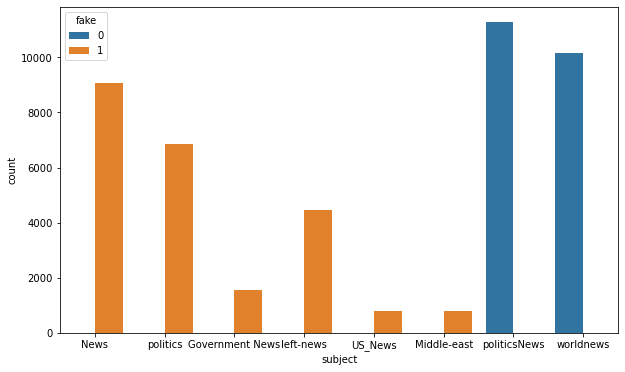

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=news, hue='fake')

This clearly shows that any news which is not of "policticsNews or worldnews" is a fake news. This perfectly seggregates the data into two classes and hence is not a choice for classification modelling. We would drop this attribute before we begin modelling

## Feature Engineering

#### We will create a new columns called Month and Year from Date and analyse whether fake or real news has some correlation with Month or Year in the timeline

In [10]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


<AxesSubplot:xlabel='Year', ylabel='count'>

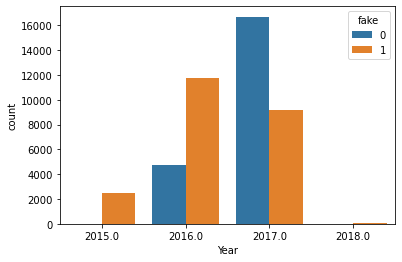

In [11]:
# Check the impact of Year on the target variable
sns.countplot(x='Year', data=news, hue='fake')

All news in the year 2015 in the dataset is a fake news. So this attribute has a level which perfectly distributes the target variable.

<AxesSubplot:xlabel='Month', ylabel='count'>

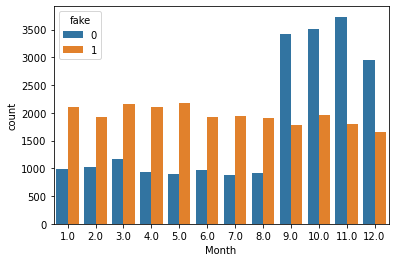

In [12]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='fake')

This shows an interesting pattern - The number of fake news is higher till month 8, post which the number of real news increases drastically. Which essentially means if the month is <= 8, the probability of fake news is higher. 

#### We will combine the title and text column

In [13]:
news['text'] = news['title'] + news['text']
news.drop(labels=['title'], axis=1, inplace=True)

news.head()

,text,subject,date,fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,News,2017-12-25,1,2017.0,12.0


## Preparing the final data

We will remove the subject attribute - Since it perfectly distributes the target variable
We will remove the Year attribute - This also has a clear division for the target variable
We will remove the Month Attribute - This also has a very clear approach of demarcating the target variable

For now we will just go ahead with the "text attribute"

In [14]:
news.drop(labels=['subject', 'date', 'Year', 'Month'], axis=1, inplace=True)
news.head()

,text,fake
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


## Train-Test Split

In [15]:
# We will shuffle the dataframe and extract the feature and label

news = news.sample(frac=1)
feature_text = news['text']
target = news['fake']

In [16]:
# Perform the split
features_train, features_test, target_train, target_test = train_test_split(feature_text, target, test_size=0.3, 
                                                                            random_state=101)

# We will further split the training set into validatoion to evaluate the Neural Network training
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.3, 
                                                                            random_state=101)

print("Training Features shape: ", features_train.shape)
print("Training Target shape: ", target_train.shape)

print("Validation Features shape: ", features_val.shape)
print("Validation Target shape: ", target_val.shape)

print("Test Features shape: ", features_test.shape)
print("Training Target shape: ", target_test.shape)

Training Features shape:  (21999,)
Training Target shape:  (21999,)
Validation Features shape:  (9429,)
Validation Target shape:  (9429,)
Test Features shape:  (13470,)
Training Target shape:  (13470,)


In [17]:
# First 10 training samples
features_train[: 10]

12888    Exclusive: EU parliament details UK concession...
2037     Fellow Republicans rebuke Trump over governmen...
17372    (VIDEO) OBAMA ON LETTERMAN: “WE IGNORE POCKETS...
9305     WHY IS AL SHARPTON’S “Half-Brother” Registerin...
3452     Trump's Paris decision followed debate between...
23032    Tucker Carlson to Border Angels Founder: Why S...
19470    WAR HAWK, ANTI-TRUMPER RINOS Join Dems To Inve...
23014    Uber, Google, Twitter, Netflix and Other Tech ...
20375    HILLARY SHARES PRO-ILLEGAL MANIFESTO: Plans To...
13100    Arab League says U.S. should not take measures...
Name: text, dtype: object

In [18]:
# First 10 training classes (target)
target_train[: 10]

12888    0
2037     0
17372    1
9305     1
3452     0
23032    1
19470    1
23014    1
20375    1
13100    0
Name: fake, dtype: int64

## Build and Train the Neural Network Model

#### Global Model Constants

In [19]:
# Define some global Model Constants

INPUT_SHAPE = []

OUTPUT_UNITS = 1
HIDDEN_UNITS_SINGLE = 16
HIDDEN_UNITS_DEEP = 8
ACTIVATION_HIDDEN = tf.keras.activations.relu
ACTIVATION_OUTPUT = tf.keras.activations.sigmoid
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy(from_logits=True)
L2_REGULARIZER = tf.keras.regularizers.L2(0.001)
DROPOUT_RATE = 0.2

EPOCHS = 10

#### Define the Model evaluation Metrics

In [20]:
# Define the Metrics - These are the metrics we will evaluate during training

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

#### In order to perform text processing, we would be using a pre-trained embedding layer from tensorflow-hub
We will create a Keras Layer that uses tensorflow hub model to embed sentences

#### The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using (google/nnlm-en-dim128/2) splits the sentence into tokens, embeds each token and then combines the embedding.

In [21]:
model_embeddings = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(model_embeddings, input_shape=INPUT_SHAPE, dtype=tf.string, trainable=True)

# We will use it in the first two samples and check
hub_layer(features_train[:2])

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 3.5389798 ,  0.13877736, -0.11152294, -0.44289574,  0.03254172,
        -0.03038158, -0.11837737,  0.13463207, -0.05818722,  0.7797247 ,
         0.5990895 ,  0.45504925, -0.46730435, -0.19992603, -0.6561821 ,
        -0.23830962, -0.6399208 , -0.55007714, -0.66278654,  2.9924052 ,
         0.20922278,  0.59934145, -0.24670699,  0.08166138,  0.30055538,
        -0.10486384,  0.17486313,  0.24651863, -0.13233322, -0.3414264 ,
         0.24359624,  0.15711407,  0.26340744,  0.14855193,  0.2881938 ,
         0.24605332, -0.26088935, -0.6108484 , -0.3096457 ,  0.05995395,
         0.4466654 ,  0.1080626 , -0.3345897 ,  0.617818  ,  0.10740822,
         0.18125726, -0.11761041,  0.07662797,  0.33516008, -0.2244343 ,
         0.4656322 ,  0.08141618,  0.5141374 , -0.02736491, -0.7082774 ,
        -0.132357  , -0.49593782,  0.46261218,  0.19500802,  0.02939369,
        -0.15539043,  0.25139135,  0.22228555, -0.40980554, -0.17684741,
 

### Building and Compiling the Model

We will build two models 

**Simple Model** - Without any regularization and dropout and a single hidden layer<br>
**Deep Neural Model** - With multiple hidden layers, L2 regularization and Dropouts <br><br>

**Performace Graph Functions** - We will define functions for plotting performance graphs
- Training Loss vs Validation Loss
- Training Accuracy vs Validation Accuracy

In [22]:
# Defining a function which will build and compile the model

'''
This will build and compile a model with one hidden layer and 16 neurons
'''
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS_SINGLE, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [23]:
'''
This will build a deep neural network model with multiple hidden layers and implement 
L2 regularization
Dropout regularization
'''

def make_DNNModel(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS_DEEP, activation=ACTIVATION_HIDDEN, kernel_regularizer=L2_REGULARIZER))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS_DEEP, activation=ACTIVATION_HIDDEN, kernel_regularizer=L2_REGULARIZER))
    model.add(tf.keras.layers.Dropout(rate=DROPOUT_RATE))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [24]:
# Defining a function to plot training loss vs validation loss

'''
This function will take a epoch model from training a neural network
Will plot training loss vs validation loss
'''

def plotTrainLossVsValLoss(epochs_history):
    plt.figure(figsize=(12, 8))
    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    epochs = range(1, 11)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training Loss vs Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [25]:
# Defining a function to plot training accuracy vs validation accuracy

'''
This function will take a epoch model from training a neural network
Will plot training accuracy vs validation accuracy
'''

def plotTrainAccuracyVsValAccuracy(epochs_history):
    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['accuracy']
    loss_val = epochs_history.history['val_accuracy']

    epochs = range(1,11)
    plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
# Defining a function to plot the confusion matrix
# Let us visualize the Confusion Matrix and detail out some key metrices including classification report

'''
This function will plot the confusion matrix 
This will also display various performance metrices
'''
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix %0.2f" %threshold)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print("\n")
    print("F1-Score")
    print(f1_score(target_test, target_predictions > 0.5))
    print("\n")
    print("Accuracy Score")
    print(accuracy_score(target_test, target_predictions > threshold))
    print("\n")
    print("Classification Report")
    print(classification_report(target_test, target_predictions > 0.5))

#### Compile the Simple Model

In [27]:
# Lets build the model and see the mmodel summary

simplemodel = make_model()
simplemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [28]:
# we will now train the model on training and validation data
# Now use the function to plot the confusion matrix

start = datetime.now()
epochs_history_simple = simplemodel.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)
end = datetime.now()
print(f"The training of simple model completed in time - {end - start}")

Epoch 1/10
688/688 [==============================] - 44s 61ms/step - loss: 0.0603 - tp: 11354.0000 - fp: 178.0000 - tn: 10290.0000 - fn: 177.0000 - accuracy: 0.9839 - precision: 0.9846 - recall: 0.9847 - auc: 0.9985 - val_loss: 0.0093 - val_tp: 4964.0000 - val_fp: 8.0000 - val_tn: 4448.0000 - val_fn: 9.0000 - val_accuracy: 0.9982 - val_precision: 0.9984 - val_recall: 0.9982 - val_auc: 0.9996
Epoch 2/10
688/688 [==============================] - 42s 61ms/step - loss: 0.0012 - tp: 11529.0000 - fp: 1.0000 - tn: 10467.0000 - fn: 2.0000 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9998 - auc: 1.0000 - val_loss: 0.0071 - val_tp: 4965.0000 - val_fp: 6.0000 - val_tn: 4450.0000 - val_fn: 8.0000 - val_accuracy: 0.9985 - val_precision: 0.9988 - val_recall: 0.9984 - val_auc: 0.9996
Epoch 3/10
688/688 [==============================] - 43s 63ms/step - loss: 9.5831e-04 - tp: 11529.0000 - fp: 3.0000 - tn: 10465.0000 - fn: 2.0000 - accuracy: 0.9998 - precision: 0.9997 - recall: 0.9998 - auc: 1.

#### Check Performance Graphs

<Figure size 864x576 with 0 Axes>

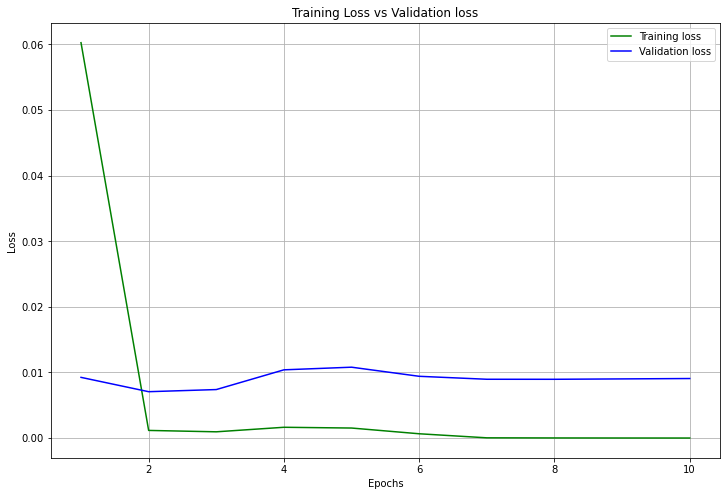

In [29]:
# Plot training loss vs validation loss
plotTrainLossVsValLoss(epochs_history=epochs_history_simple)

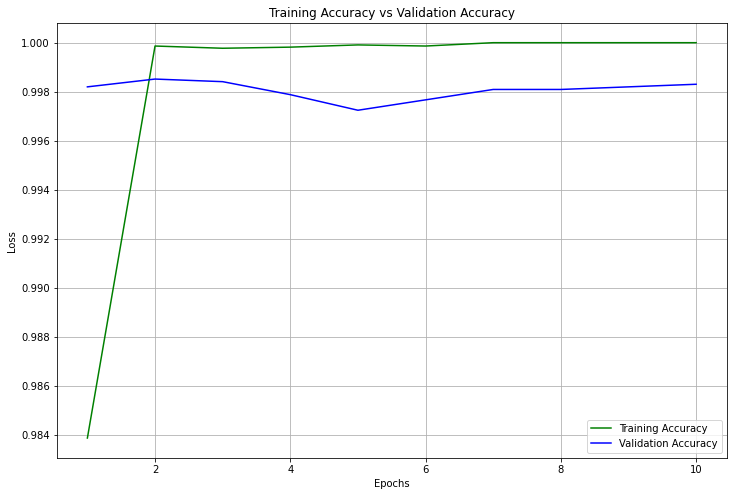

In [30]:
# Plot Training accuracy vs Validation accuracy
plotTrainAccuracyVsValAccuracy(epochs_history=epochs_history_simple)

#### Model Validation for the Simple Model

In [32]:
# Let us run the predictions
target_predictions = simplemodel.predict(features_test)

Legitimate Transactions Detected (True Negatives):  6478
Legitimate Transactions Incorrectly Detected (False Positives):  15
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  6957
Total Fraudulent Transactions:  6977


F1-Score
0.9974908595598251


Accuracy Score
0.9974016332590943


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6493
           1       1.00      1.00      1.00      6977

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



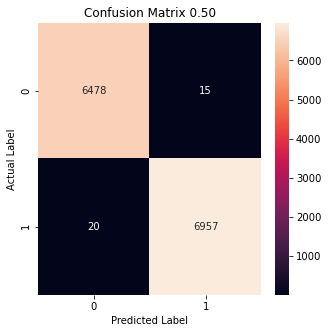

In [33]:
# Now use the function to plot the confusion matrix
plot_cm (target_test, target_predictions)

### We will build Deep Neural Model with L2 Regularization and Dropouts - Hyperparameter Tuning

#### Compile the Deep Neural Model

In [34]:
'''
This will build a deep neural network model with multiple hidden layers and implement 
L2 regularization
Dropout regularization
'''

deepmodel = make_DNNModel()
deepmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 124,643,801
Trainable params: 124,643,801
Non-trainable params: 0
_________________________________________________________________


#### Train the Deep Neural Model

In [35]:
# we will now train the model on training and validation data
# Now use the function to plot the confusion matrix

start = datetime.now()
epochs_history_deep = deepmodel.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)
end = datetime.now()
print(f"The training of simple model completed in time - {end - start}")

Epoch 1/10
688/688 [==============================] - 45s 63ms/step - loss: 0.0557 - tp: 16431.0000 - fp: 209.0000 - tn: 14715.0000 - fn: 73.0000 - accuracy: 0.9910 - precision: 0.9874 - recall: 0.9956 - auc: 0.9996 - val_loss: 0.0204 - val_tp: 4965.0000 - val_fp: 7.0000 - val_tn: 4449.0000 - val_fn: 8.0000 - val_accuracy: 0.9984 - val_precision: 0.9986 - val_recall: 0.9984 - val_auc: 0.9996
Epoch 2/10
688/688 [==============================] - 44s 63ms/step - loss: 0.0202 - tp: 11515.0000 - fp: 2.0000 - tn: 10466.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.9998 - recall: 0.9986 - auc: 1.0000 - val_loss: 0.0144 - val_tp: 4961.0000 - val_fp: 5.0000 - val_tn: 4451.0000 - val_fn: 12.0000 - val_accuracy: 0.9982 - val_precision: 0.9990 - val_recall: 0.9976 - val_auc: 0.9999
Epoch 3/10
688/688 [==============================] - 46s 66ms/step - loss: 0.0157 - tp: 11518.0000 - fp: 3.0000 - tn: 10465.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.9997 - recall: 0.9989 - auc: 1.00

#### Deep Neural Model Performance Graphs

<Figure size 864x576 with 0 Axes>

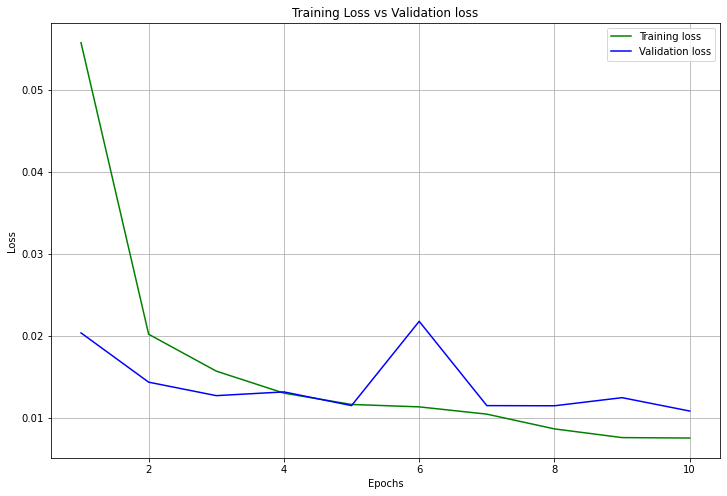

In [36]:
# Plot Training Loss vs Validation Loss for the Deep Neural Model
plotTrainLossVsValLoss(epochs_history=epochs_history_deep)

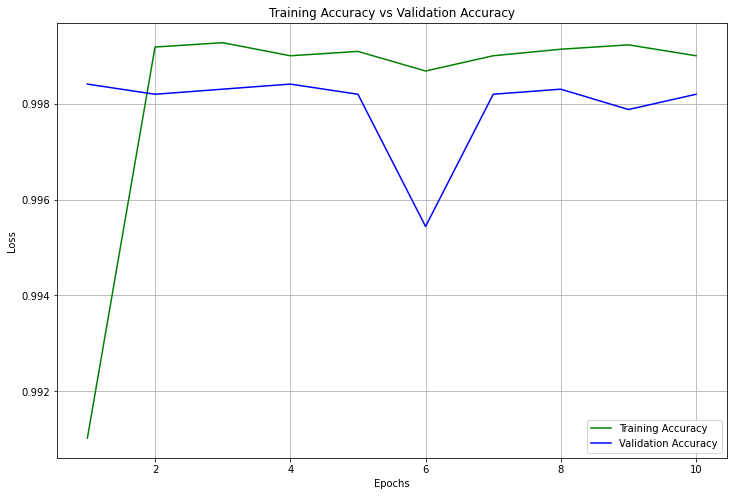

In [37]:
# Plot the Training Accuracy vs Validation Accuracy for the Deep Neural Model
plotTrainAccuracyVsValAccuracy(epochs_history=epochs_history_deep)

#### Model Validations for the Deep Neural Model

In [38]:
# Let us run the predictions

target_predictions = deepmodel.predict(features_test)

Legitimate Transactions Detected (True Negatives):  6477
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  6964
Total Fraudulent Transactions:  6977


F1-Score
0.9979221895822884


Accuracy Score
0.9978470675575353


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6493
           1       1.00      1.00      1.00      6977

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



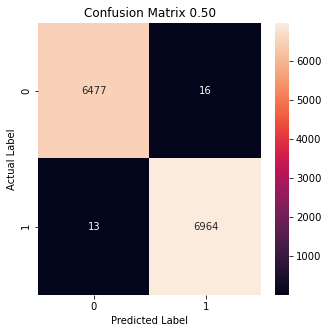

In [39]:
# Now use the function to plot the confusion matrix
plot_cm (target_test, target_predictions)